# CMSC320 Final Tutorial
Jatin Dewani

<img src='img.png' alt="Anime Picture">  
<sup>image courtesy of https://en.wikipedia.org/wiki/Anime</sup>  
# <center>Predicting Whether an Anime is "Good"</center>

## Introduction & Motivation
For the uninitiated, anime is a form of 2-D animation usually associated with being made in Japan. It is a relatively newer form of entertainment which differs in the traditional media in the sense its expressionism isn't bound by the real world. Therefore, artists can take liberties with their work and create something which can be pretty hard to portray in real-life movies/TV shows. 

Nowadays, there is a lot of anime being released, therefore, there is a lot of choice for the viewers. However, because there is a lot of choice, it also means that a viewer has a higher probability of choosing an anime that they won't like. Though an anime may be highly rated, it's not necessary someone new to the medium may like it. Therefore, my motivation in making this tutorial is to see classify whether an anime is "good" or not, i.e., will someone with no prior background in the medium watching it for the first time like it or not.
    
The libraries needed for this tutorial are listed below, I will be listing the purpose of every one of these libraries' functions as I use them throughout the tutorial, you may read more about them in their respective documentation (links at the bottom).

In [1]:
from bs4 import BeautifulSoup
import requests
from datetime import datetime
import csv
import re
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

## Data Collection & Cleaning
To start, we are going to have to collect relevant data to then make a model that can predict whether somebody will like an anime or not. To do that, I decided to scrape https://myanimelist.net/, which is a website that scores and ranks anime. It has a record for nearly every anime out there. Also, the anime_id, which then orders them by, are linearly ordered, meaning that we can get sufficient information by just iterating through the anime_id field in its URL.

We will start by writing a function that can get us the relevant information from a page. We will suppose that a beautifulSoup object (I will describe how to do this below) is passed into the function. Our objective is to collect relevant quantitative and categorical information about a given anime. I narrowed down the following relevant parameters which would help us in our model:
1. Name: Name of the anime
2. Season: The Season in which the anime was premiered. (Broadcasting schedules usually follow seasons)
3. Year: The year in which the anime was premiered.
4. Type: Type of the medium. (TV, Movie, OVA (Original Video Animation), ONA (Original Net Animation), Music, Special)
5. Episodes: Number of episodes.
6. Start_date: Start date of anime.
7. Rating: PG rating of the anime.
8. Score: Score of the anime (1-10 scale).
9. Rank: Rank of the anime.
10. Popularity: Popularity of the anime.

I located all of these on the page with the help of the functions provided in the BeautifulSoup library functions, converting them to the appropriate types. If a page is missing the name attribute, then I just return a dictionary with 'name' key set to none, this is because this page is an error landing page which indicates there is no anime associated with the given anime_id. If I do find the name parameter, then it is not an error page, and I can parse the data, so I set the appropriate values of the parameters if any of them are missing. There won't be any need to additionally clean/modify the data later on. The return value is a dictionary with all of the values appropriately set. To know more about web scraping and the differences compared to APIs, you can follow this link: https://blog.hartleybrody.com/web-scraping/.

In [2]:
def doRow(soup):
    data = {}
    try:
        data['Name'] = soup.find('span', string='English:').next_sibling.strip()
    except AttributeError:
        try:
            data['Name'] = soup.find('span', itemprop='name').string
        except AttributeError:
            data['Name'] = None
            return data;
    try:
        mid = soup.find('span', string='Premiered:').find_next('a').string.split(' ')
        data['Season'] = mid[0]
        data['Year'] = int(mid[1])
    except (AttributeError, ValueError):
        data['Season'] = 'nan'
        data['Year'] = None
    try:
        data['Type'] = soup.find('span', string='Type:').next_sibling.next_sibling.string.strip()
    except AttributeError:
        data['Type'] = None
    try:
        data['Episodes'] = int(soup.find('span', string='Episodes:').next_sibling.strip())
    except (AttributeError, ValueError):
        data['Episodes'] = 0
    try:
        data['Start_date'] = datetime.strptime(soup.find('span', string='Aired:').next_sibling.strip().lower().split(' to ')[0], '%b %d, %Y').date()
        if(data['Year'] is None):
            data['Year'] = data['Start_date'].year
    except AttributeError:
        data['Start_date'] = None
    try:
        data['Rating'] = soup.find('span', string='Rating:').next_sibling.strip()
        if (re.match("^Rx", data['Rating']) or re.match("^R\+", data['Rating'])):
            data['Rating'] = 'R - 18'
    except AttributeError:
        data['Rating'] = None
    try:
        data['Score'] = float(soup.find('span', string='Score:').find_next_sibling('span').string.strip())
    except (AttributeError, ValueError):
        data['Score'] = None
    try:
        data['Rank'] = int(soup.find('span', string='Ranked:').next_sibling.strip().replace("#", ""))
    except (AttributeError, ValueError):
        data['Rank'] = None
    try:
        data['Popularity'] = int(soup.find('span', string='Popularity:').next_sibling.strip().replace(',', '').replace('#', ''))
    except (AttributeError, ValueError):
        data['Popularity'] = None
    return data

I decided to get data for the first 35,000 anime_ids, as I figured that it would be more than enough to train the model. We can get a page's information by using the requests library, and then parse it's HTML content via beautiful soup to then pass it on to the function given above.

Also, as there are a lot of pages being opened and parsed, there is a high chance of a ConnectionError, therefore, I decided to skip over any iteration which returns a ConnectionError, for a more complete dataset, you could not increment the value of I when there's a ConnectionError, which would make it retry until you get the value for a specific anime_id.

I also decided to make the data persist in a CSV file as soon as it is read, because it takes a long time to go through so many pages, in case of some unexpected error, one could just rerun the program with the appropriate value of I so as not to go through all of the pages whose values have already been collected.

In [3]:
i = 1
fieldnames = ['anime_id', 'Name', 'Season', 'Type', 'Rank', 'Episodes', 'Year', 'Start_date', 'Score', 'Rating', 'Popularity']
with open('fin2', mode='w') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    
    while (i <= 35000):
        try:
            page =  requests.get("https://myanimelist.net/anime/" + str(i))
            soup = BeautifulSoup(page.content, 'html.parser')
            data = doRow(soup)
            data['anime_id'] = i
            if (data['Name'] is None):
                i+=1
                continue
            writer.writerow(data)
            i+=1
        except ConnectionError:
            i+=1
            continue

An example of what the data looks like is given below (converted to a pandas dataframe):

In [4]:
data = pandas.read_csv("fin2.csv")
data.head()

,anime_id,Name,Season,Type,Rank,Episodes,Year,Start_date,Score,Rating,Popularity
0,1,Cowboy Bebop,Spring,TV,27.0,26,1998,1998-04-03,8.81,R - 17+ (violence & profanity),38
1,5,Cowboy Bebop: The Movie,NaN,Movie,157.0,1,2001,2001-09-01,8.41,R - 17+ (violence & profanity),438
2,6,Trigun,Spring,TV,234.0,26,1998,1998-04-01,8.31,PG-13 - Teens 13 or older,138
3,7,Witch Hunter Robin,Summer,TV,2292.0,26,2002,2002-07-02,7.34,PG-13 - Teens 13 or older,1104
4,8,Beet the Vandel Buster,Fall,TV,3400.0,52,2004,2004-09-30,7.04,PG - Children,3495


Now that we have data about the Anime, we need to have a comparison variable which tells us whether a person would want to watch an anime or not, this is how we decide if the anime is 'good' or not. A good way to quantify it would be to gather user data and get a proportion of users who like the anime. Thankfully MyAnimeList has user data that would allow us to do that. Instead of trying to read in such a huge user dataset, I found a Kaggle dataset that would get us the relevant information. The dataset https://www.kaggle.com/CooperUnion/anime-recommendations-database#rating.csv gives us what a user rated an anime. We are interested in the proportion of users who liked the anime. To quantify a person 'liking' something, I decided a score of 8 and above would signify it. Therefore, I went through the dataset and counted the number of people who 'liked' (gave it a rating of 8 or above) an anime, and the total number of people who scored it. Dividing the 2 values would give us the desired proportion. 

Again, as the dataset is very large (hence, the computing time is very large), I decided to write the output to a CSV file. 

In [5]:
dat = pandas.read_csv("rating.csv")
n = pandas.DataFrame(columns = ['anime_id'])
n['anime_id'] =  np.sort(dat.anime_id.unique())
n['prob_like'] = 0
n['tot'] = 0
n = n.set_index('anime_id')

for index, row in dat.iterrows():
    if(row['rating'] >= 8 and row['rating'] != -1):
        n.loc[row['anime_id']] += 1
    else:
        n.loc[row['anime_id']][1] += 1
n.to_csv("outputFF.csv", index= False)

In [6]:
out = pandas.read_csv("outputFF.csv")

In [7]:
data.shape

(6172, 11)

In [8]:
out.shape

(11200, 3)

Now that we have two different datasets, we just need to merge them based on the correct anime_id. We can clearly see that the two have different numbers of entries. Therefore, we can perform an inner join on the two to get the relevant data (with no null output values). We need to set their indexes to anime_id to perform that operation. We also don't need anime without a sufficient number of total votes in our dataset, as that could give biased results. I deleted the anime with less than 20 total votes to accomplish this. I also dropped all rows with NaN values in the rank column as it would not be possible to replace an anime's rank with a non-exact value.

In [9]:
out = out.set_index('anime_id')
data = data.set_index('anime_id')
data = pandas.concat([data, out], axis = 1, join='inner')
data = data[data['tot'] >= 20]
data = data.dropna(subset=['Rank'])
data['Rank'] = data['Rank'].astype('int32')
data.head()

,Name,Season,Type,Rank,Episodes,Year,Start_date,Score,Rating,Popularity,prob_like,tot
anime_id,,,,,,,,,,,,
1,Cowboy Bebop,Spring,TV,27,26,1998,1998-04-03,8.81,R - 17+ (violence & profanity),38,11724,15509
5,Cowboy Bebop: The Movie,NaN,Movie,157,1,2001,2001-09-01,8.41,R - 17+ (violence & profanity),438,4715,6927
6,Trigun,Spring,TV,234,26,1998,1998-04-01,8.31,PG-13 - Teens 13 or older,138,7460,11077
7,Witch Hunter Robin,Summer,TV,2292,26,2002,2002-07-02,7.34,PG-13 - Teens 13 or older,1104,1149,2629
8,Beet the Vandel Buster,Fall,TV,3400,52,2004,2004-09-30,7.04,PG - Children,3495,130,413


## Exploratory Data Analysis
Now that we have the data collected and cleaned, we can start an exploratory analysis which tells us the relationship between the different input variables to themselves and the output variables.  

Firstly, we will check if there is a a direct correlation between an anime's rank and popularity by creating a scatterplot with a regression line.

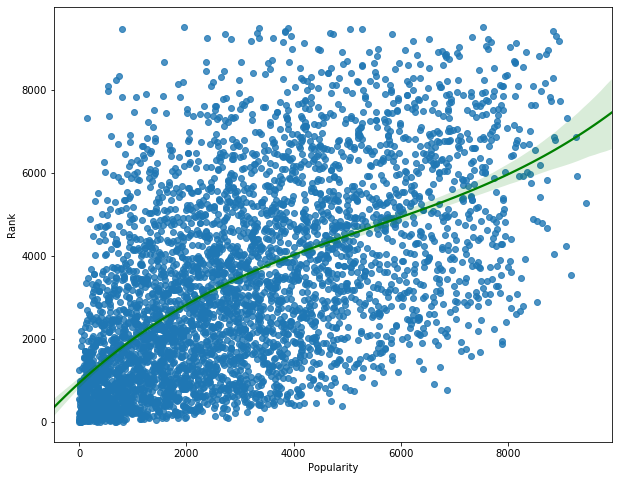

In [10]:
plt.figure(figsize=(10, 8))
sns.regplot(x = data['Popularity'], y = data['Rank'], order = 3, line_kws = {'color':'green'})

Looking at the plot, we can see that apart from a generally increasing trend, there is no visible relation between an anime's rank and popularity. Therefore, we can see that score may not be the only parameter to go by when considering whether someone will like an anime or not. We try to look at some more trends to figure out how the score changes throughout the years.

Now, let's see what the scores of anime are in comparison to years by making a scatterplot with seaborn and adding a regression line to see if there are any patterns visible

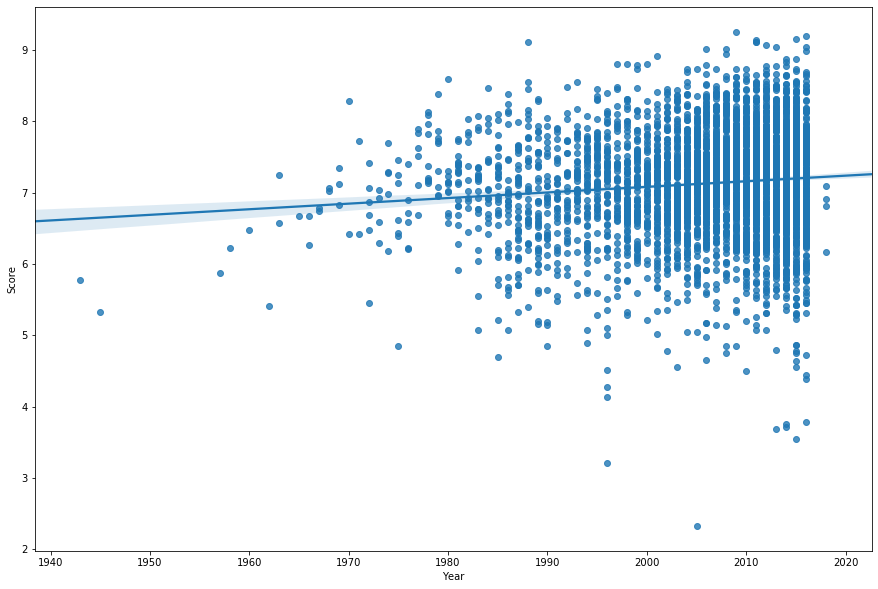

In [11]:
plt.figure(figsize=(15, 10))
sns.regplot(x = data['Year'], y = data['Score'], order = 1)

As we can clearly see, there is a slight upward trend in the Scores of anime as the years go on. However, we can clearly see that in the earlier years there are much less anime for there to be a clear trend. Therefore, we cannot be sure if there is a correlation between the score of an anime and the year it was released in. Therefore, we need to have a depiction which shows us the distributions of anime scores in the later years where there is enough data to form conclusions. 

To that purpose, I created a boxplot which shows the distributions of different anime's scores for each year after 2000.

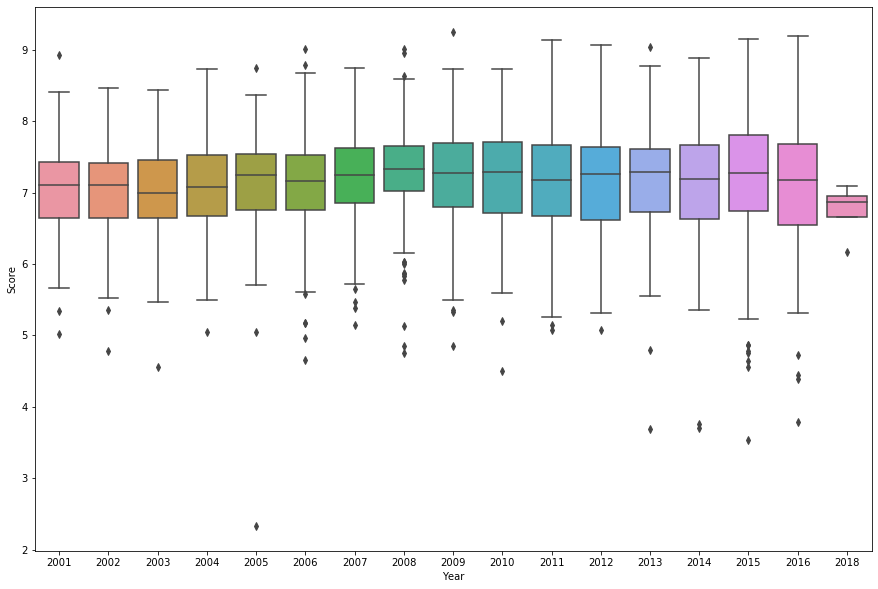

In [12]:
plt.figure(figsize=(15,10))
mi = data[(data['Year'] > 2000)]
sns.boxplot(x = mi['Year'], y = mi['Score'])

We can clearly see that the distributions are near identical, as the figures for all of them are nearly the same. This means that their means and standard deviations are nearly the same with no linear increasing or decreasing pattern. Therefore, we can conclude that there is no significant effect on the anime's scores as time goes on.

Moving on, to get an idea of how the parameters we have to affect the possibility that a person will like an anime, I created a new variable that stores the proportion of people who 'like' (gave it a rating equal to or above 8) an anime (remember, this is the variable which lets us decide whether an anime is 'good' or not).

In [13]:
data['prop'] = data['prob_like']/data['tot']

Next, we move on to comparing how the proportion of people who like an anime change with respect to the score, rank and popularity.

In the 3 graphs below, I set the proportion as the y variable, and compare it to score, ranks, and popularity respectively.

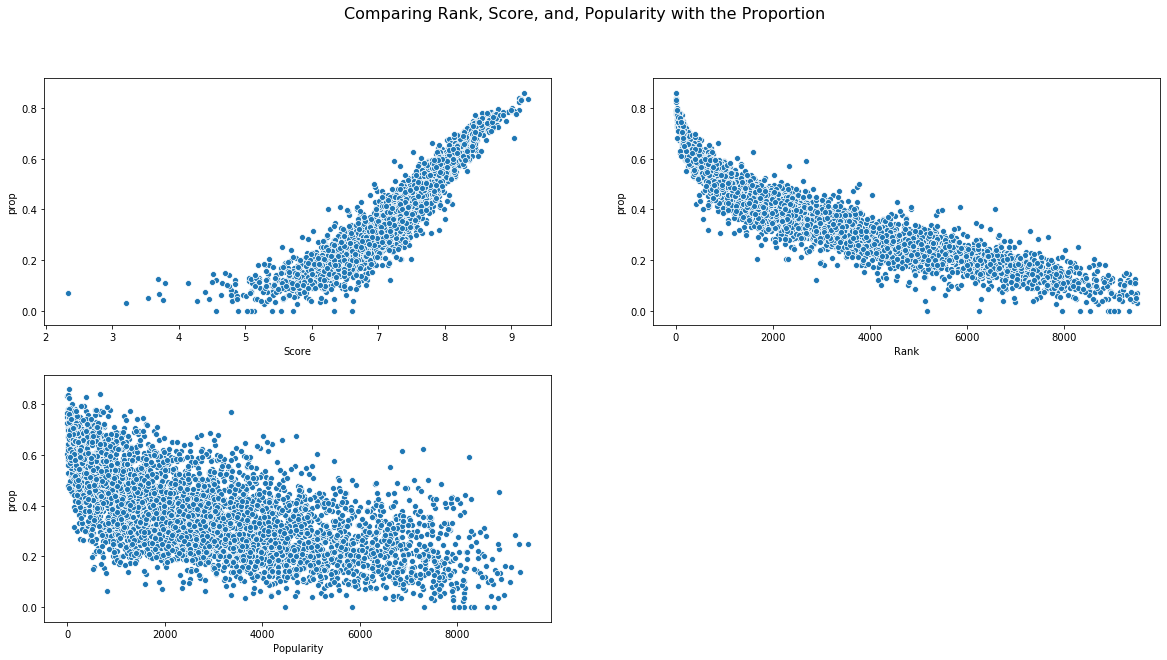

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))

sns.scatterplot(x=data['Score'], y = data['prop'], ax = axes[0,0])
sns.scatterplot(x=data['Rank'], y = data['prop'], ax = axes[0,1])
sns.scatterplot(x=data['Popularity'], y = data['prop'], ax = axes[1,0])

fig.suptitle('Comparing Rank, Score, and, Popularity with the Proportion', fontsize=16)
fig.delaxes(axes[1, 1])

In the graphs above, we can see some clear patterns. Firstly, looking at the comparison of score to proportion, we can clearly see that as the score increases, the proportion of people who like the given anime seems to increase linearly. Looking at the second graph, we can see that although not linear, there is a correlation between an anime's rank and the proportion of people who like it. Lastly, there doesn't seem to be much correlation between an anime's popularity and the proportion of people who like it.

To further analyze the relationship between an anime's rank and the proportion of people who like it, let's plot a line plot that shows what the difference in scores is like the rank changes.

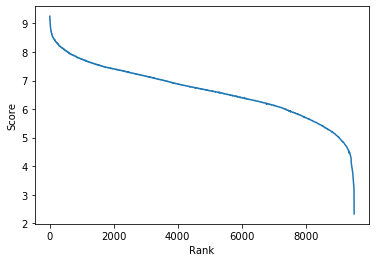

In [15]:
sns.lineplot(data=data, x='Rank', y='Score')

We can more clearly see that although an anime's rank depends on its score, the difference in scores is not even throughout the board. For the top-rated anime, there seems to be a higher difference in between each anime's score than the ones in the middle. The same inverse pattern can be seen at the bottom. This explains the non-linear nature of the proportion of people who like a given anime to its rank. The correlation seems to be that a higher proportion of people like a top-rated anime than the ones below it, and the differences are steeper at the top.

Moving on, we will try to figure out if there is a relationship between different kinds of content Ratings and the proportion. I did this by making a violin plot with seaborn.

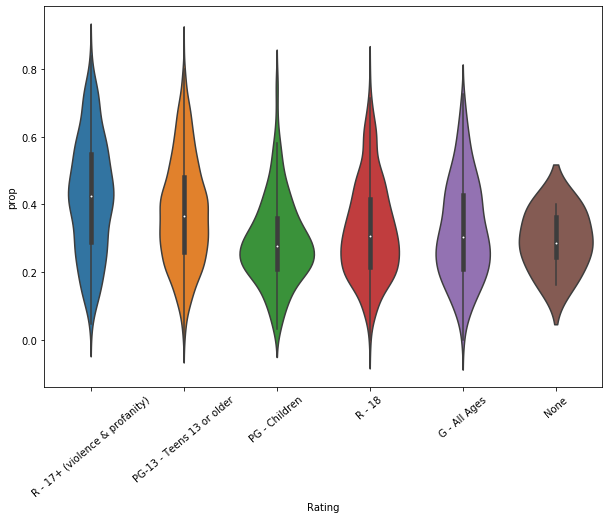

In [16]:
plt.figure(figsize=(10,7))
plt.xticks(rotation=40)
sns.violinplot(data=data, x='Rating', y='prop')

Looking at the violin plot, we can see that there is some kind of relation between the Rating and proportion. One thing that stands out is that the anime with the rating 'None' doesn't seem to have a proportion above .5 liking them.

Next, let's try to see the relative difference in the frequency of each type. We can do this by making a barplot with pandas' inbuilt plot() function.

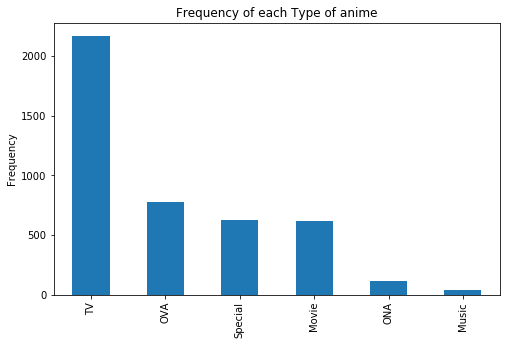

In [17]:
data['Type'].value_counts().plot(kind='bar',
                                    figsize=(8,5),
                                    title="Frequency of each Type of anime").set_ylabel("Frequency")
plt.show()

We can clearly see that the overwhelming majority of anime are in the form of TV shows, we try to see if there a difference in the proportion of people who like a certain type by comparing the means of the proportion for all the types.

In [18]:
data.groupby(['Type']).mean()['prop']

Type
Movie      0.417370
Music      0.276105
ONA        0.269241
OVA        0.310846
Special    0.300670
TV         0.398891
Name: prop, dtype: float64

At first glance, it may look like the proportions for each type vary, if you take a look at the barplot, it becomes clear that the proportions vary by the number of entries for each Type. Therefore, as the data is not significant for some mediums (ONA, Music), we will not include this variable in our model.

Finally, we will take a look at the Season parameter to see if it has some kind of correlation to proportion. For this, we will create a line plot with a separate line for each season. We will take a subset of 10 years from 2000 to 2010 and plot the mean of proportion for a given season for every year.

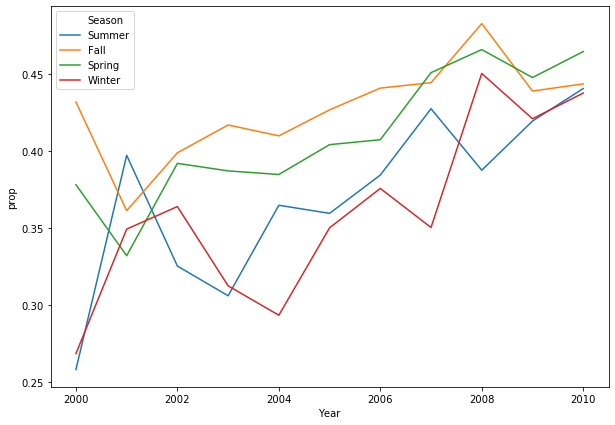

In [19]:
plt.figure(figsize=(10,7))
mid = data[data['Year'] >= 2000]
mid = mid[mid['Year'] < 2011]
sns.lineplot(data=mid, x='Year', y='prop', hue='Season', estimator= np.mean, err_style = None)

Looking at the plot, there seems to be clearly some kind of relation between the 2 variables, as we see that more often than not, the best-received anime air in the Fall season.

## Creating the Model
Now that we have a decent idea of which variables are relevant for us to input into our model, we will prepare our input and outputs accordingly. I will be using random forests for this problem. The input variable will be 1 if the proportion of people who like an anime are above 0.5, and 0 otherwise. I chose random forests because it is good in reducing overfitting, and is a good algorithm for supervised learning (which our problem clearly fits).

First, we will prepare our independent and dependent variables. To accomplish this, I first created a new data frame with all the quantitative variables. Then, I created dummy variables for all the categorical variables which we found to be useful. I created the (dependent) variable as described above.

In [20]:
data = data.reset_index()
X = data[['Score', 'Rank', 'Popularity', 'Episodes']].copy()
dum_R = pandas.get_dummies(data['Rating'])
dum_S = pandas.get_dummies(data['Season'])
X = pandas.concat([X, dum_R, dum_S], axis = 1)
y = np.zeros(data.shape[0])

for index, row in data.iterrows():
    if row['prop'] > .5:
        y[index] = 1
y = y.astype(int)
data['y'] = y
X.head()

,Score,Rank,Popularity,Episodes,G - All Ages,None,PG - Children,PG-13 - Teens 13 or older,R - 17+ (violence & profanity),R - 18,Fall,Spring,Summer,Winter
0,8.81,27,38,26,0,0,0,0,1,0,0,1,0,0
1,8.41,157,438,1,0,0,0,0,1,0,0,0,0,0
2,8.31,234,138,26,0,0,0,1,0,0,0,1,0,0
3,7.34,2292,1104,26,0,0,0,1,0,0,0,0,1,0
4,7.04,3400,3495,52,0,0,1,0,0,0,1,0,0,0


Now that we have the input and output variables, we need to figure out the best hyperparameter values for our model. I did this using the gridSearchCV function which does an exhaustive grid search over all the parameters values.

In [21]:
search = {'n_estimators': [5, 10, 20, 30, 50],
               'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [3, 4, 5],
               'max_depth': [2, 3, 5, 10, 15, 50],
               'min_samples_split': [2, 5, 10, 15, 20]}

model = GridSearchCV(RandomForestClassifier(), search, cv=5, scoring='precision')

We can now fit the data and the GridSearchCV function will run and compare the model with all the different kinds of parameters and return the best one.

In [22]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
model.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

We can fit the best parameters to now compare the accuracy of the model.

In [23]:
f = model.best_params_
mod = RandomForestClassifier(max_depth = f['max_depth'], max_features = f['max_features'], min_samples_leaf = f['min_samples_leaf'], \
                             min_samples_split=f['min_samples_split'], n_estimators=f['n_estimators'])

We compare the accuracy by doing cross-validation. It basically means splitting the dataset into 2 parts, one is used to train the model, and the other one is used to input data into the trained model and compare the output. The accuracy is simply the percentage of correct predictions. We do this 10 times, and then get the average Accuracy of the model.

In [24]:
Accuracy = []
X_a = np.array(X)
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test = X_a[train_index], X_a[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ret = mod.fit(X_train, y_train)
    Accuracy.append(np.sum(ret.predict(X_test) == y_test)/test_index.shape[0])
Average_Accuracy = np.mean(Accuracy) * 100

In [25]:
Average_Accuracy

94.49923195084486

We can clearly see that the accuracy of the model is pretty good. More than 90% of the time, our model can correctly predict whether or not more than half the proportion of viewers will like an anime based on the input parameters. 

## Conclusion
Now that we have a model that can predict whether an anime is 'good' or not (based on popular opinion), it can be used on any anime that is present on the myAnimeList website. It can basically be used to get a Yes or No answer to the question "Should I watch this?". I believe that it can be a little intimidating to get into watching a particular anime, that's why I decided to pursue this as the topic for my tutorial. What I believe I accomplished is a primitive version of a recommendation system that is nowadays widely used to curate content on the internet. An actual recommender system takes in a lot more information than just the basic numeric data about something. If you are interested in learning more about these, then I recommend checking out this link: https://medium.com/recombee-blog/recommender-systems-explained-d98e8221f468. It basically gives a rundown of the what and how of a recommender system.

I have all the datasets (except the Kaggle one) I used on this page's Github repo. Though I used a basic regression algorithm to make the model, there are a lot of different options I could have chosen from. There are a lot of good classification algorithms which could be useful in different kinds of datasets, more information about them can be found here: https://medium.com/@Mandysidana/machine-learning-types-of-classification-9497bd4f2e14. I encourage the reader to take a look at these and try them out on some other datasets (which can be found on https://kaggle.com). Maybe even try making your own recommender system!

The Documentation for all the nonstandard libraries I used is listed as follows:  
[BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
[Requests](https://requests.readthedocs.io/en/master/)
[SciKit-Learn](https://scikit-learn.org/stable/)
[Seaborn](https://seaborn.pydata.org/)
[matplotlib](https://matplotlib.org/3.1.1/contents.html#)
[Pandas](https://pandas.pydata.org/pandas-docs/stable/)
[Numpy](https://numpy.org/doc/)